In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import numpy as np
import utils
from ImageMatcher import ImageMatcher, ImagePair
import h5py
from scipy.spatial.transform import Rotation as Rot
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
from glob import glob
import os
import sys
import copy

In [3]:
DATA_DIR = '/Users/richard/Desktop/Motorized-Dataset/'
TRAJ_DIR = DATA_DIR

in_vid_paths = sorted(glob(DATA_DIR + '*.mp4'))

in_vid_path = in_vid_paths[26]
in_vid_stem = Path(in_vid_path).stem

frames = utils.load_video(in_vid_path,
                          grayscale=True)
masks = np.load(DATA_DIR + in_vid_stem + '-masks.npz')['masks']
video_width = frames[0].shape[1]

kf_interval = 30

print('Using video:', in_vid_stem)
print('n_frames:', len(frames))

Using video: t026-v05
n_frames: 900


In [4]:
matcher = ImageMatcher(frames, human_masks=masks, keyframe_interval=kf_interval)

In [15]:
img_pairs_path = DATA_DIR + in_vid_stem + '-pairs.h5'
image_pairs = []
closures = []
still_cnt = 0
override = False

if not override and os.path.isfile(img_pairs_path):
    print('Loading existing file', img_pairs_path)
    image_pairs = utils.import_image_pairs(img_pairs_path, frames)
    for p in image_pairs:
        if p.still:
            still_cnt += 1
        if p.i != p.j - 1:
            closures.append(p)
else:

    for i in range(0, len(frames) - 1):
        p = matcher.match(
            i, i+1,
            min_match_count=60,
            ransac_max_iters=2000,
            #keep_percent=0.5,
            verbose=True,
        )
        if p is None:
            print('No match found for frames', i, i+1)
        image_pairs.append(p)

    for i in range(0, len(frames) - kf_interval, kf_interval):
        for j in range(i + kf_interval, len(frames), kf_interval):
            if matcher.sift_kds[i] is None or matcher.sift_kds[j] is None:
                continue
            p = matcher.match(i, j, 'sift',
                            min_match_count=25)
            if p is None:
                continue
            closures.append(p)
            image_pairs.append(p)


print('Number of loop closures:', len(closures))

print('Total number of image pairs:', len(image_pairs))

print('Number of still pairs:', still_cnt)

if override or (not os.path.isfile(img_pairs_path)):
    utils.export_image_pairs(img_pairs_path, image_pairs)

Loading existing file /Users/richard/Desktop/Motorized-Dataset/t026-v05-pairs.h5
Number of loop closures: 57
Total number of image pairs: 956
Number of still pairs: 582


In [10]:
# 13 seconds
image_pairs = matcher.lk_track()
utils.export_image_pairs(img_pairs_path, image_pairs)

100%|██████████| 900/900 [00:12<00:00, 72.95it/s] 


In [ ]:
for p in closures:
    print(f'Number of matches from {p.i} to {p.j}: {len(p.src_pts)}')
    utils.visualize_matches(p)

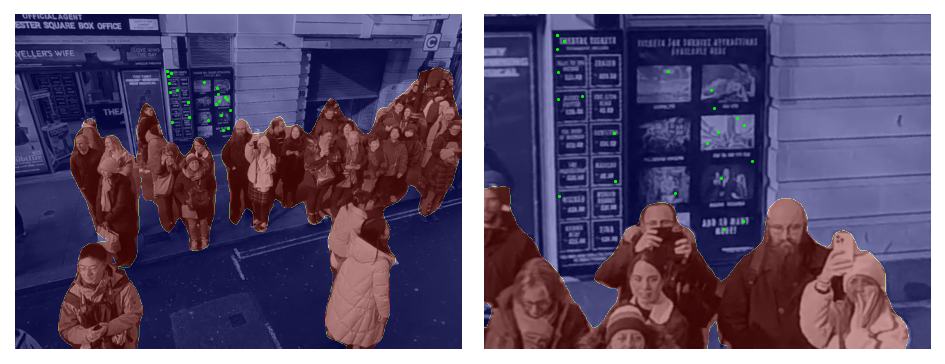

In [45]:
for p in image_pairs:
    if (p.i, p.j) == (150, 570):
        utils.visualize_matches(p, dpi=150, masks=masks)

In [51]:
opt_cmd = [
    '../Ceres/build/estimate', DATA_DIR, in_vid_stem + '-pairs.h5',
    'yes',  # enable loop closures
    'no',  # load existing camera params
    'no',   # use_stills
]
ret = subprocess.run(opt_cmd)
if ret.returncode != 0:
    print(f'Ceres exited with non-zero return code!')

Enabling loop closure constraints.
Optimizing poses for t026-v05.
Loaded 956 image pairs.
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.384317e+07    0.00e+00    3.18e+07   0.00e+00   0.00e+00  1.00e+04        0    2.41e-01    4.82e-01
   1  1.072328e+06    2.28e+07    2.15e+06   0.00e+00   9.99e-01  3.00e+04        1    5.32e-01    1.01e+00
   2  2.521085e+05    8.20e+05    7.01e+05   7.24e+03   1.12e+00  9.00e+04        1    3.75e-01    1.39e+00
   3  1.654760e+05    8.66e+04    4.81e+05   4.19e+03   1.21e+00  2.70e+05        1    3.62e-01    1.75e+00
   4  1.481465e+05    1.73e+04    5.01e+05   3.23e+03   6.58e-01  2.79e+05        1    3.73e-01    2.12e+00
   5  1.318345e+05    1.63e+04    6.89e+04   7.41e+02   1.07e+00  8.36e+05        1    3.80e-01    2.50e+00
   6  1.312398e+05    5.95e+02    2.85e+04   2.55e+02   1.29e+00  2.51e+06        1    4.60e-01    2.96e+00
   7  1.311621e+05    7.77e+01    1.45e+04   5

Reference frame: 810
angular error mean: 1.25184, max: 15.55572
hfov error mean: 0.86718, max: 6.64419


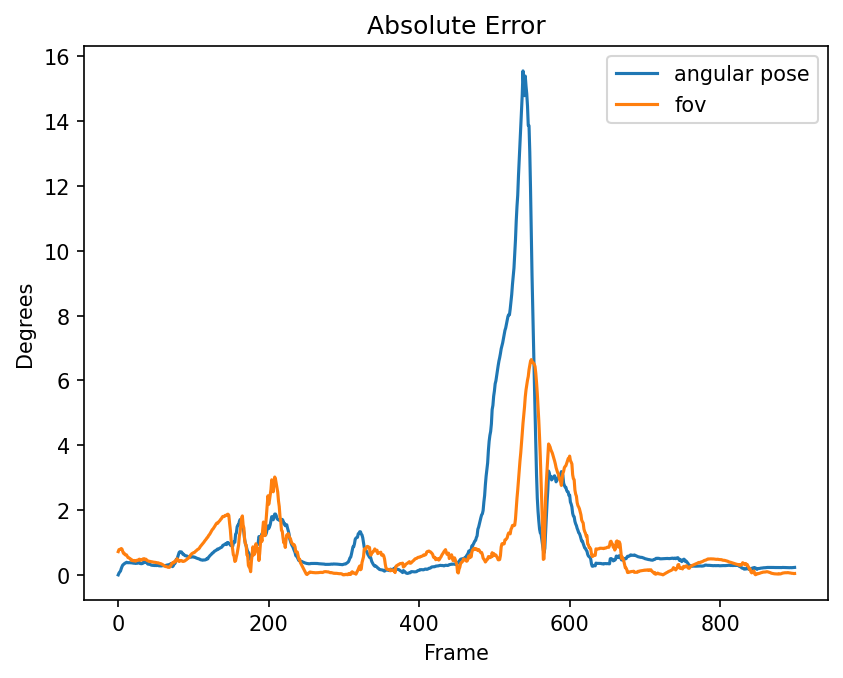

In [52]:
ref_idx = utils.frame_with_most_loop_closures(image_pairs)
print(f'Reference frame: {ref_idx}')

cpe, cpg = utils.load_est_gt_poses(
    in_vid_path, video_width)

cam_params_est, cam_params_gt = utils.set_ref_cam(0, cpe, cpg)

# Compute the angular pose error and hfov error between cam_params and cam_params_gt
angular_err_abs = []
angular_err_rel = []
hfov_err_abs = []
hfov_err_rel = []
cam_indices = []

for i in sorted(cam_params_est.keys()):
    R = cam_params_est[i]['R']
    R_gt = cam_params_gt[i]['R']

    ae = np.degrees(Rot.from_matrix(R @ R_gt.T).magnitude())
    angular_err_abs.append(ae)
    angular_err_rel.append(ae / max(np.degrees(Rot.from_matrix(R_gt.T).magnitude()), 0.1))

    hfove = np.abs(cam_params_est[i]['hfov'] - cam_params_gt[i]['hfov'])
    hfov_err_abs.append(hfove)
    hfov_err_rel.append(hfove / cam_params_gt[i]['hfov'])
    cam_indices.append(i)

print(f'angular error mean: {np.mean(angular_err_abs):.5f}, '
      f'max: {np.max(angular_err_abs):.5f}')
print(f'hfov error mean: {np.mean(hfov_err_abs):.5f}, max: {np.max(hfov_err_abs):.5f}')

fig, ax = plt.subplots(dpi=150)
ax.set_title('Absolute Error')
ax.plot(angular_err_abs, label='angular pose')
ax.plot(hfov_err_abs, label='fov')
ax.set_xlabel('Frame')
ax.set_ylabel('Degrees')
#ax.set_ylim(-0.5, 10)
#ax.set_yticks(np.arange(0, 8.5, 2))
ax.legend()
plt.show()

In [50]:
aea_w_motion_comp = copy.deepcopy(angular_err_abs)
hea_w_motion_comp = copy.deepcopy(hfov_err_abs)

In [84]:
print(f'angular error mean: {np.mean(aea_w_motion_comp):.5f}, '
      f'max: {np.max(aea_w_motion_comp):.5f}')
print(f'hfov error mean: {np.mean(hea_w_motion_comp):.5f}, max: {np.max(hea_w_motion_comp):.5f}')

angular error mean: 0.54065, max: 2.54263
hfov error mean: 0.76461, max: 3.93182


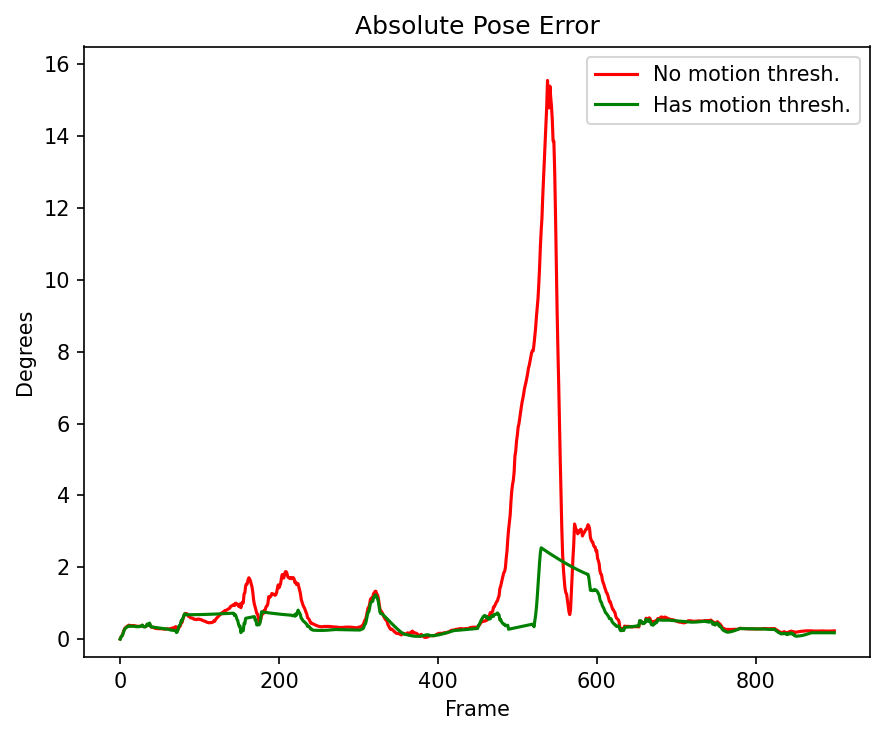

In [69]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 5))
ax.set_title('Absolute Pose Error')
ax.plot(angular_err_abs, label='No motion thresh.', color='red')
ax.plot(aea_w_motion_comp, label='Has motion thresh.', color='green')
ax.set_xlabel('Frame')
ax.set_ylabel('Degrees')
ax.set_ylim(-0.5, 16.5)
#ax.set_yticks(np.arange(0, 8.5, 2))
#ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

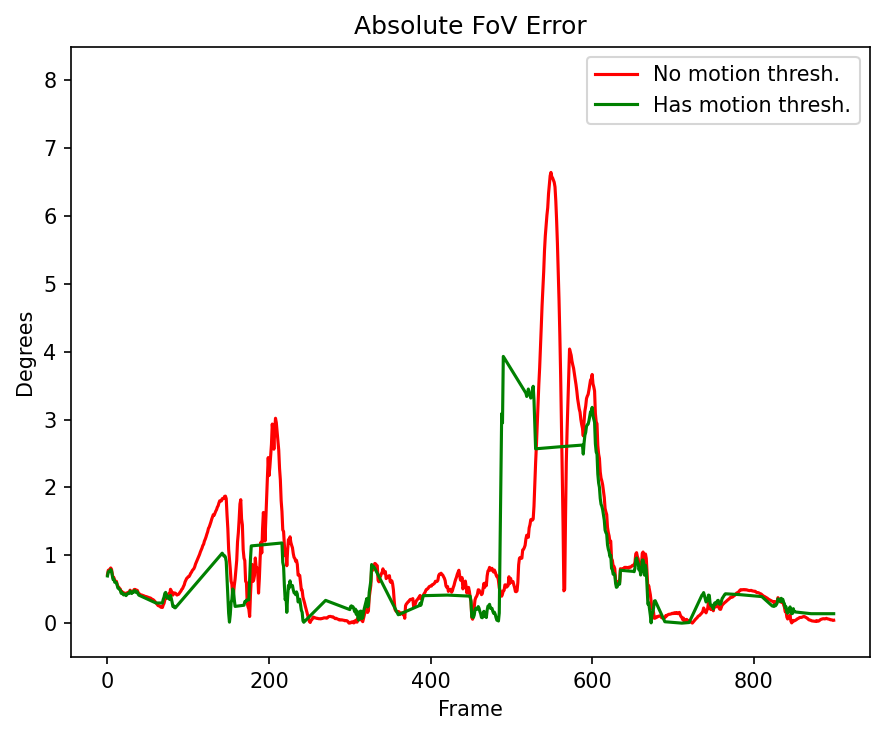

In [70]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 5))
ax.set_title('Absolute FoV Error')
ax.plot(hfov_err_abs, label='No motion thresh.', color='red')
ax.plot(hea_w_motion_comp, label='Has motion thresh.', color='green')
ax.set_xlabel('Frame')
ax.set_ylabel('Degrees')
ax.set_ylim(-0.5, 8.5)
#ax.set_yticks(np.arange(0, 8.5, 2))
ax.legend()
fig.tight_layout()
plt.show()

In [39]:
np.argmax(angular_err_abs), np.argmax(hfov_err_abs)

(530, 490)

In [ ]:
utils.visualize_matches(image_pairs[1])

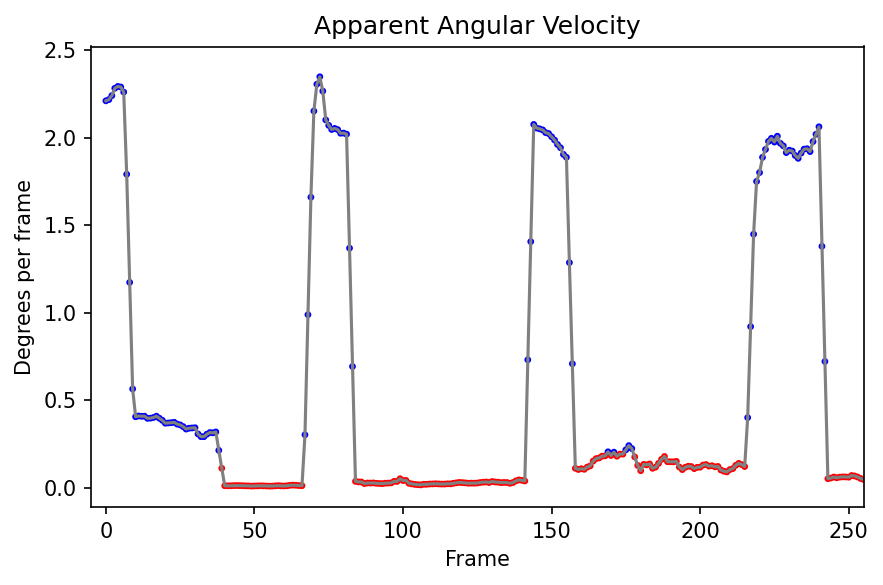

In [82]:
idx2pair = {}
for p in image_pairs:
    idx2pair[(p.i, p.j)] = p

av = []
for i in range(0, len(frames) - 1):
    p = idx2pair[(i, i+1)]
    av.append(utils.avg_quad_angular_velocity(p, cam_params_est[i]))

# Moving average filter to smooth out the angular velocity
# preserve the length of the array (padding = same as edge)
av.insert(0, av[0])
av.append(av[-1])
av = np.convolve(av, np.ones(3) / 3, mode='valid')

still_thresh = 0.2
fig, ax = plt.subplots(dpi=150, figsize=(6, 4))
ax.set_title('Apparent Angular Velocity')
ax.plot(av, color='gray')
ax.scatter(np.arange(0, len(av)), av, c=['red' if a < still_thresh
                                          else 'blue' for a in av], s=5)
ax.set_xlim(-5, 255)
ax.set_xlabel('Frame')
ax.set_ylabel('Degrees per frame')
fig.tight_layout()
plt.show()

In [14]:
cnt = 0
for i in range(0, len(av)):
    p = idx2pair[(i, i+1)]
    p.still = av[i] < still_thresh
    if p.still:
        cnt += 1
print(f'Number of still pairs: {cnt}')

utils.export_image_pairs(img_pairs_path, image_pairs)

Number of still pairs: 582
